In [1]:
import sys
import warnings
if '../' not in sys.path:
    sys.path.append('../')

warnings.filterwarnings("ignore")

In [2]:
import src.utils as ut

In [3]:
# !pip install shap==0.44.1
# !pip install ipywidgets

In [4]:
conf = ut.get_conf()

#### What are SHAP values?
We've seen (and used) techniques to extract general insights from a machine learning model. But what if we want to break down how the model works for an individual prediction?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where can we use this?

- A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

#### How they work!

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

An example is helpful, and we'll continue the soccer/football example from the permutation importance and partial dependence plots lessons.

In these tutorials, we predicted whether a team would have a player win the Man of the Match award.

We could ask:

- How much was a prediction driven by the fact that the team scored 3 goals?
But it's easier to give a concrete, numeric answer if we restate this as:

- How much was a prediction driven by the fact that the team scored 3 goals, **instead of some baseline number of goals.**
Of course, each team has many features. So if we answer this question for `number of goals`, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:

`sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values`

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:

![alt text](../img/JVD2U7k.png)


How do you interpret this?

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds).



In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [6]:


import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X, y = shap.datasets.california(n_points=1_000)

In [7]:
shap.__version__

'0.44.1'

In [8]:
data = ut.read_csv_file(conf['save_paths']['fifa_data'], 'FIFA 2018 Statistics')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [9]:
row_to_show = 1
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

array([[0.39, 0.61]])

In [10]:
my_model.predict(val_X.iloc[0:1])

array([False])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [11]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model = my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [12]:
shap_values

[array([-0.08833915, -0.02001169, -0.00276174, -0.01325802,  0.00807934,
        -0.01102612, -0.02013066, -0.00801844, -0.02549644, -0.01171549,
         0.01781642,  0.0044108 ,  0.05462514,  0.00857633, -0.00261282,
        -0.00015245, -0.00098522,  0.0022502 ]),
 array([ 0.08833915,  0.02001169,  0.00276174,  0.01325802, -0.00807934,
         0.01102612,  0.02013066,  0.00801844,  0.02549644,  0.01171549,
        -0.01781642, -0.0044108 , -0.05462514, -0.00857633,  0.00261282,
         0.00015245,  0.00098522, -0.0022502 ])]

The `shap_values` object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out `shap_values[1]`).

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)
# shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.

- `shap.DeepExplainer` works with Deep Learning models.
- `shap.KernelExplainer` works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using KernelExplainer to get similar results. The results aren't identical because `KernelExplainer` gives an approximate result. But the results tell the same story.

In [14]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

### For medical dataset

Assume that we have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

We'll start after the point where you've built a basic model. Just run the following cell to build the model called `my_model`.

Dataset description,

- prediction target is `readmitted`.
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428". What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`.
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.

In [17]:
data = ut.read_csv_file(conf['save_paths']['hospital_data'], 'train')

In [18]:
y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

You have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

In [20]:
#plot 1
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


In [19]:
# Plot 2: Show an Example of the Model Running Inference w/ SHAP values
import shap  # package used to calculate Shap values

data_for_prediction = val_X.iloc[5,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

It appears number_inpatient is a really important feature. The doctors would like to know more about that. Let's create a graph for them that shows how `num_inpatient` affects the model's predictions.

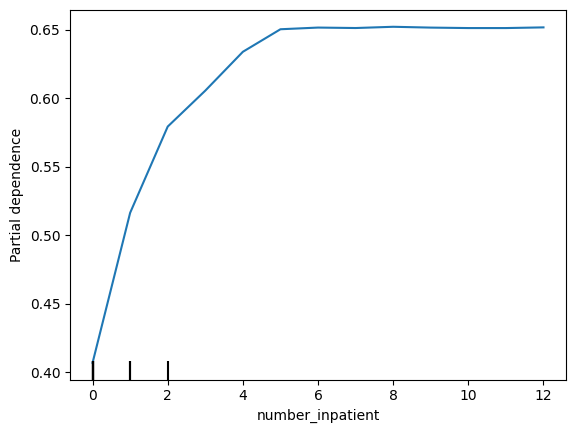

In [22]:
feature_name = 'number_inpatient'
PartialDependenceDisplay.from_estimator(my_model, val_X, [feature_name])
plt.show()

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions. But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

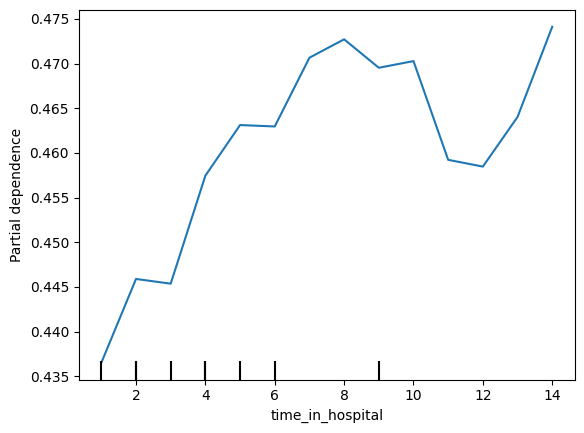

In [23]:
feature_name = 'time_in_hospital'
PartialDependenceDisplay.from_estimator(my_model, val_X, [feature_name])
plt.show()

Woah! It seems like `time_in_hospital` doesn't matter at all. The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could the data be wrong, or is your model doing something more complex than they expect?

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot.
- Are the results similar or different?

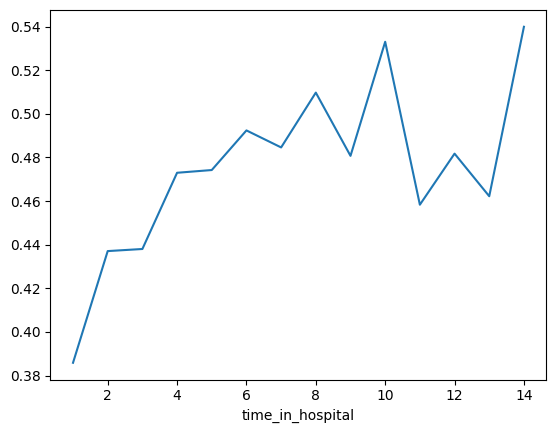

In [24]:
all_train = pd.concat([train_X, train_y], axis=1)

all_train.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

Now the doctors are convinced you have the right data, and the model overview looked reasonable. It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function patient_risk_factors that does the following

- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk. It's fine to focus on only the most important features for that patient.

In [25]:
sample_data_for_prediction = val_X.iloc[0].astype(float)  # to test function

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

In [26]:
patient_risk_factors(my_model, sample_data_for_prediction)

#### Summary Plots

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.
SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the soccer data:

![alt text](../img/Ew9X3su.png)

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.
For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

Some things you should be able to easily pick out:

- The model ignored the Red and Yellow & Red features.
- Usually Yellow Card doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
- High values of Goal scored caused higher predictions, and low values caused low predictions

In [31]:
data = ut.read_csv_file(conf['save_paths']['fifa_data'], 'FIFA 2018 Statistics')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

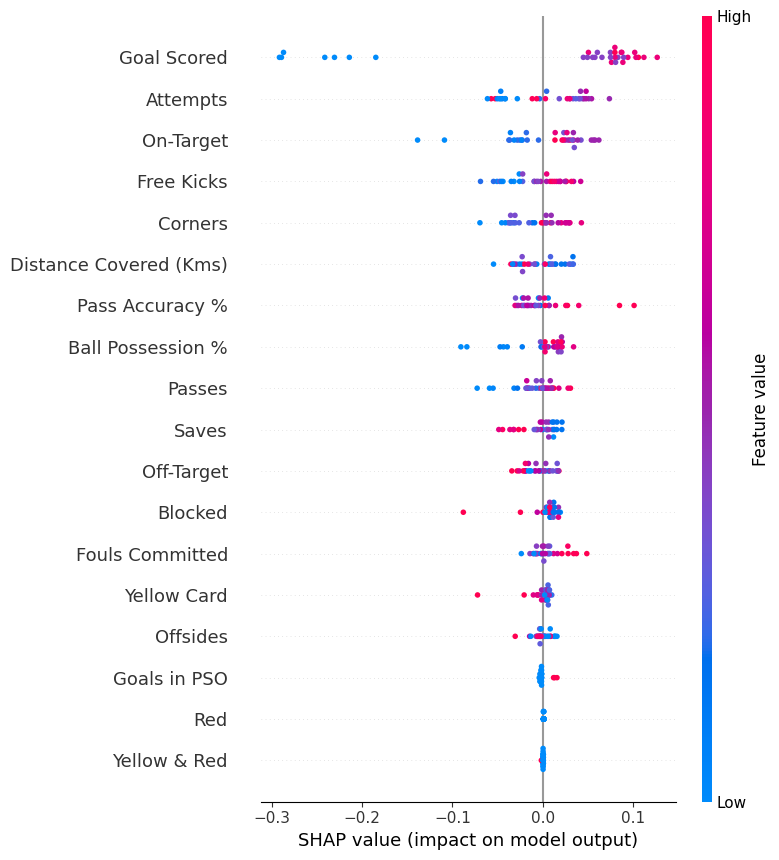

In [32]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.

- When plotting, we call `shap_values[1]`. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

#### SHAP Dependence Cotribution Plots

We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

![alt text](../img/uQ2JmBm.png)

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.

The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

![alt text](../img/tFzp6jc.png)

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.

Consider the following very narrow example for concreteness.

![alt text](../img/NVB3eNW.png)

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say **In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.**

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.

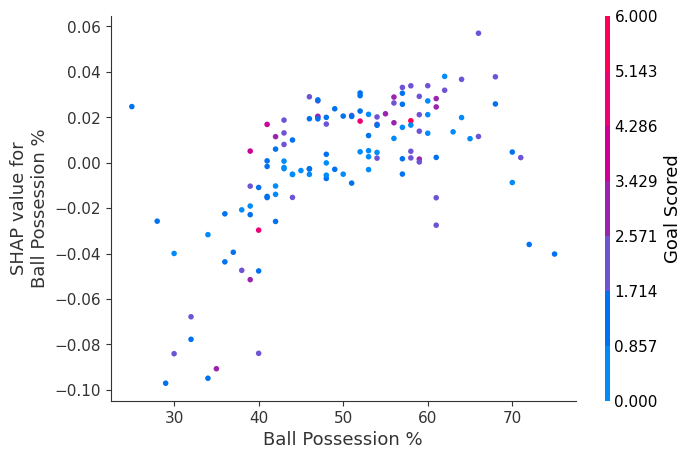

In [33]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

In [34]:
data = ut.read_csv_file(conf['save_paths']['hospital_data'], 'train')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

In [35]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


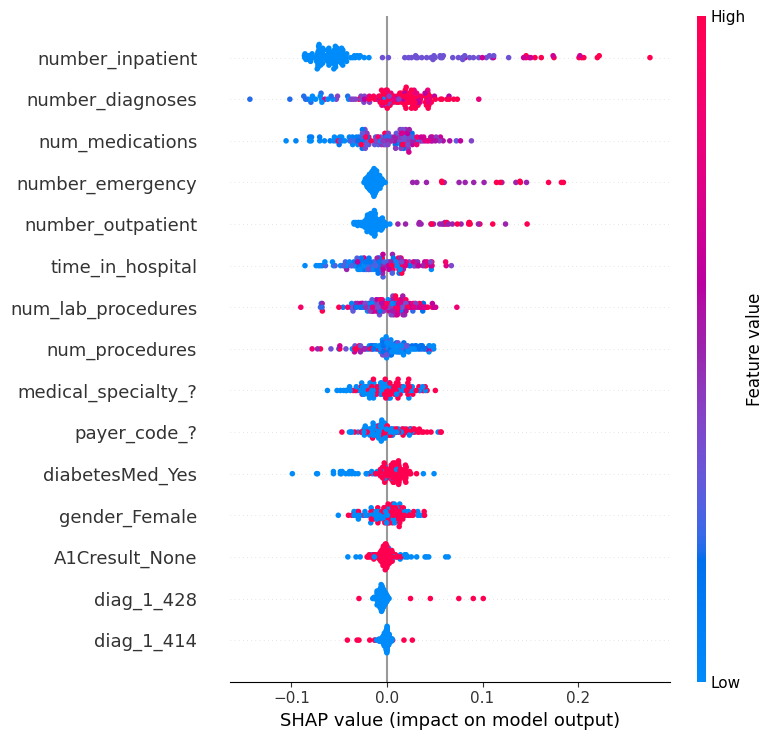

In [36]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

`diag_1_428` has a bigger range of effects on predictions compared to `payer_code_?`

Q: Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?

If the **range of effect sizes** measures something different from **permutation importance:** which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

A: No. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

Q: Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:

- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

A: While most SHAP values of diag_1_428 are small, the few pink dots (high values of the variable, corresponding to people with that diagnosis) have large SHAP values. In other words, the pink dots for this variable are far from 0, and making someone have the higher (pink) value would increase their readmission risk significantly. In real-world terms, this diagnosis is rare, but poses a larger risk for people who have it. In contrast, `payer_code_?` has many values of both blue and pink, and both have SHAP values that differ meaningfully from 0. But changing `payer_code_?` from 0 (blue) to 1 (pink) is likely to have a smaller impact than changing `diag_1_428`.


Q: Consider the following SHAP contribution dependence plot.

The x-axis shows `feature_of_interest` and the points are colored based on `other_feature`.

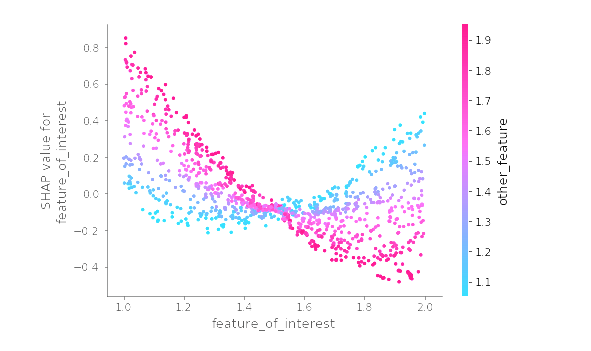

Is there an interaction between `feature_of_interest` and `other_feature`? If so, does `feature_of_interest` have a more positive impact on predictions when `other_feature` is high or when `other_feature` is low?

A:  First, recall that the SHAP vaue is an estimate of the impact of a given feature on the prediction. So, if the dots trend from upper left to lower right, that means low values of `feature_of_interest` cause higher predictions.

Returning to this graph:

`feature_of_interest` slopes downward for high values of `other_feature`. To see this, focus your eye on the pink dots (where `other_feature` is high) and imagine a best-fit line through those pink dots. It slopes down, suggesting that the prediction goes down as `feature_of_interest` increases.

Now focus your eye on the blue dots, and imagine a best fit line through those dots. It is generally pretty flat, possibly even curving up on the right side of the graph. So increasing `feature_of_interest` has a more positive impact on predictions when `other_feature` is high.

Q: Both **num_medications** and **num_lab_procedures** share that jumbling of pink and blue dots.

Aside from `num_medications` having effects of greater magnitude (both more positive and more negative), it's hard to see a meaningful difference between how these two features affect readmission risk. Create the SHAP dependence contribution plots for each variable, and describe what you think is different between how these two variables affect predictions.

As a reminder, here is the code you previously saw to create

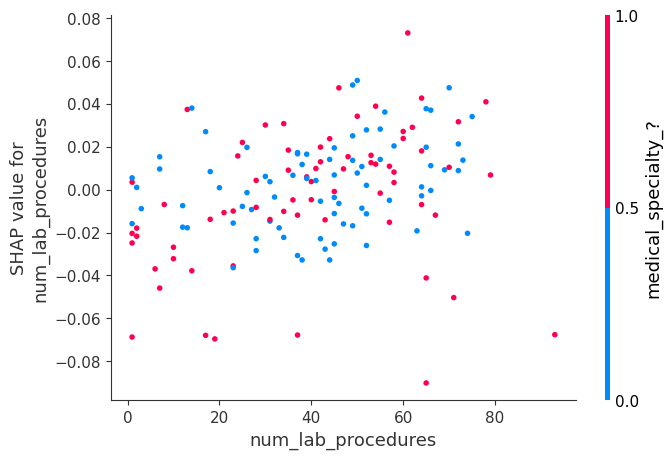

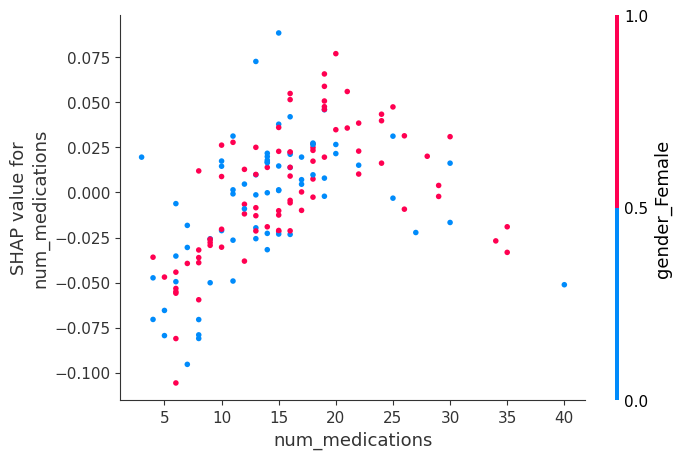

In [37]:
shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)
shap.dependence_plot('num_medications', shap_values[1], small_val_X)

Loosely speaking, **num_lab_procedures** looks like a cloud with little disernible pattern. It does not slope steeply up nor down at any point. It's hard to say we've learned much from that plot. At the same time, the values are not all very close to 0. So the model seems to think this is a relevant feature. One potential next step would be to explore more by coloring it with different other features to search for an interaction.

On the other hand, **num_medications** clearly slopes up until a value of about 20, and then it turns back down. Without more medical background, this seems a surprising phenomenon... You could do some exploration to see whether these patients have unusual values for other features too. But a good next step would be to discuss this phenomenon with domain experts (in this case, the doctors).